<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
pip install torch~=2.1.0 torch_xla[tpu]~=2.1.0 -f https://storage.googleapis.com/libtpu-releases/index.html

Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 MB 9.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: libtpu-nightly
    Found existing installation: libtpu-nightly 0.1.dev20231003
    Uninstalling libtpu-nightly-0.1.dev20231003:
      Successfully uninstalled libtpu-nightly-0.1.dev20231003

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 6.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch_xla.core.xla_model as xm
import torch_xla.distributed.parallel_loader as pl
import torch_xla.distributed.xla_multiprocessing as xmp

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [4]:
!ls /kaggle/input/faces-dataset-small/faces_dataset_small/00055.png

/kaggle/input/faces-dataset-small/faces_dataset_small/00055.png


In [5]:
pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 62.5 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 21.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


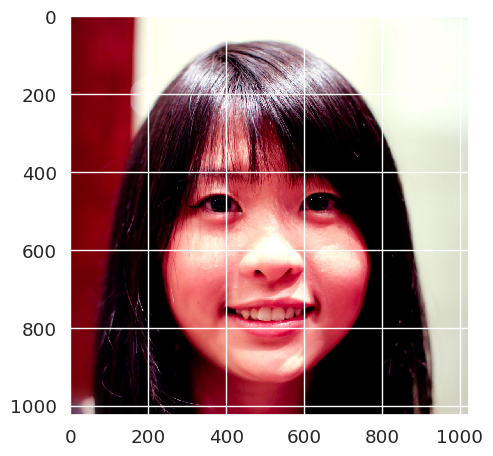

In [6]:
from skimage.io import imread,imshow
test_image=imread('/kaggle/input/faces-dataset-small/faces_dataset_small/00055.png')
imshow(test_image)

In [7]:
test_image.shape

(1024, 1024, 3)

In [8]:
DATA_DIR = '/kaggle/input/faces-dataset-small/'
image_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [9]:
def get_dataloader(image_size, batch_size):
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
        tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)]))
    return DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [10]:
device = xm.xla_device()
device

device(type='xla', index=0)

In [11]:
image_size = 64
batch_size = 512
dl = get_dataloader(image_size,batch_size)


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)



train_dl =  pl.MpDeviceLoader(dl, xm.xla_device())

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
def block_discriminator(in_c, out_c, stride=2):
    return nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=4, stride=stride, padding=1, bias=False),
        nn.BatchNorm2d(out_c),
        nn.LeakyReLU(0.2, inplace=True),
    )

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.block_1 = block_discriminator(3, 64)
        self.block_2 = block_discriminator(64, 128)
        self.block_3 = block_discriminator(128, 256)
        self.block_4 = block_discriminator(256, 512)
        # self.block_5 = block_discriminator(512, 512)
        self.conv_end = nn.Conv2d(512, 1, kernel_size=4, stride=2, bias=False)

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        # x = self.block_5(x)
        x = self.conv_end(x)
        x = x.view(x.shape[0], -1)
        x = torch.sigmoid(x)
        return x

discriminator = Discriminator()


In [13]:
discriminator = to_device(discriminator, device)

In [14]:
latent_size = 128

class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x**2, dim=1, keepdim=True) + 1e-8)

class GeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, latent_size):
        super(GeneratorBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        self.pix_norm = PixelNorm()

    def forward(self, x):
        x = self.pix_norm(x)
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.pix_norm(x)
        x = self.conv2(x)
        return x

class Generator(nn.Module):
    def __init__(self, latent_size, num_channels, num_blocks):
        super(Generator, self).__init__()
        self.initial_block = nn.ConvTranspose2d(latent_size, num_channels, kernel_size=4, stride=1, padding=0)
        self.blocks = nn.ModuleList([
            GeneratorBlock(num_channels, num_channels, latent_size) for _ in range(num_blocks)
        ])
        self.final_block = nn.Conv2d(num_channels, 3, kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        x = self.initial_block(x)
        for block in self.blocks:
            x = block(x)
        x = self.final_block(x)
        return x

latent_size = 100
num_channels = 256
num_blocks = 4

generator = Generator(latent_size, num_channels, num_blocks)

generator = to_device(generator, device)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [15]:
lr = 0.0001

model = {
    "discriminator": discriminator,
    "generator": generator
}


criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [16]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in train_dl:
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))


    return losses_g, losses_d, real_scores, fake_scores

In [17]:
epochs=30
history = fit(model, criterion, epochs, lr)

Epoch [1/30], loss_g: 1.5790, loss_d: 0.9571, real_score: 0.7081, fake_score: 0.3989
Epoch [2/30], loss_g: 2.4071, loss_d: 0.6895, real_score: 0.7717, fake_score: 0.2687
Epoch [3/30], loss_g: 2.5290, loss_d: 0.5369, real_score: 0.8175, fake_score: 0.2311
Epoch [4/30], loss_g: 2.8392, loss_d: 0.3757, real_score: 0.8432, fake_score: 0.1500
Epoch [5/30], loss_g: 3.1015, loss_d: 0.6586, real_score: 0.8056, fake_score: 0.2618
Epoch [6/30], loss_g: 2.6111, loss_d: 0.7428, real_score: 0.7350, fake_score: 0.2524
Epoch [7/30], loss_g: 2.2690, loss_d: 0.8666, real_score: 0.6932, fake_score: 0.2961
Epoch [8/30], loss_g: 2.1301, loss_d: 1.0640, real_score: 0.6358, fake_score: 0.3324
Epoch [9/30], loss_g: 2.1515, loss_d: 1.0383, real_score: 0.6473, fake_score: 0.3631
Epoch [10/30], loss_g: 1.9477, loss_d: 1.1162, real_score: 0.6352, fake_score: 0.3864
Epoch [11/30], loss_g: 1.9349, loss_d: 1.2035, real_score: 0.6142, fake_score: 0.3887
Epoch [12/30], loss_g: 1.7679, loss_d: 1.1748, real_score: 0.58

In [18]:
generator.eval()

Generator(
  (initial_block): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1))
  (blocks): ModuleList(
    (0-3): 4 x GeneratorBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (upsample): Upsample(scale_factor=2.0, mode='nearest')
      (pix_norm): PixelNorm()
    )
  )
  (final_block): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [19]:
losses_g, losses_d, real_scores, fake_scores = history

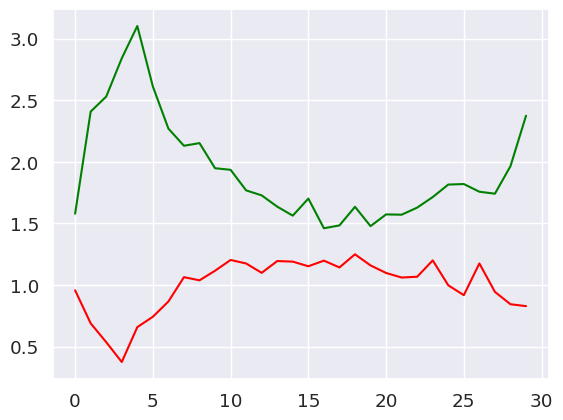

In [20]:
import matplotlib.pyplot as plt
plt.plot(losses_g,color='green')
plt.plot(losses_d,color='red')
plt.show()

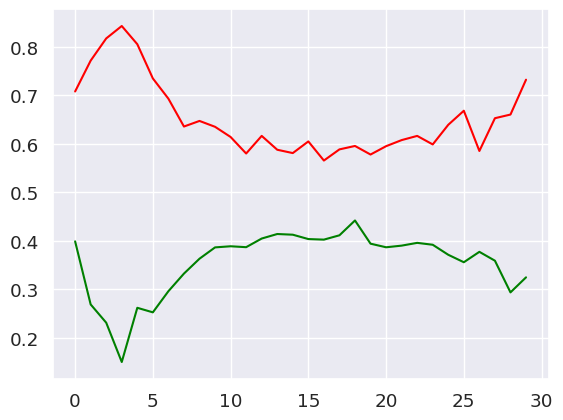

In [21]:
plt.plot(fake_scores,color='green')
plt.plot(real_scores,color='red')
plt.show()

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [22]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [79]:
import matplotlib.pyplot as plt
def show_images(generated):
    trans = tt.Normalize((1.5, 1.5,1.5), (1.5, 1.5, 1.5))
    for i in generated:
        imshow(torch.permute(trans(i), (1, 2, 0)).numpy())
        plt.show()

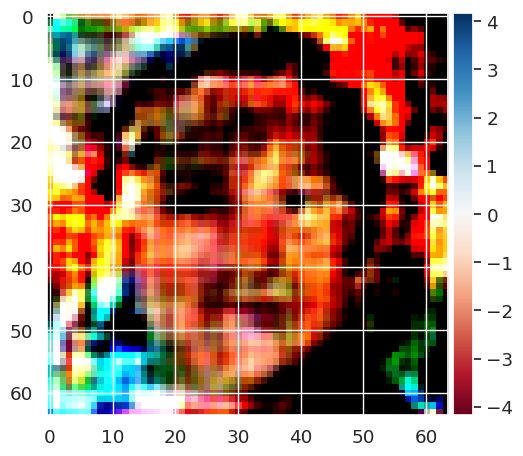

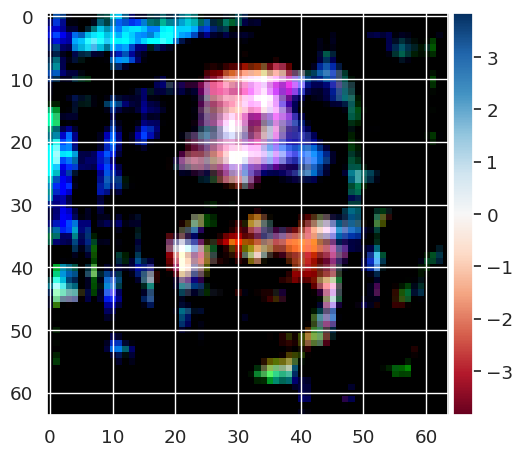

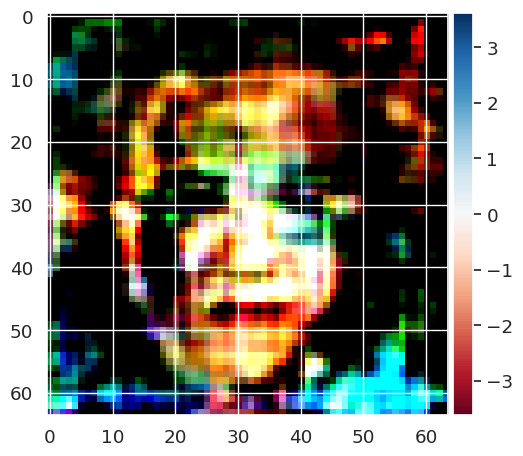

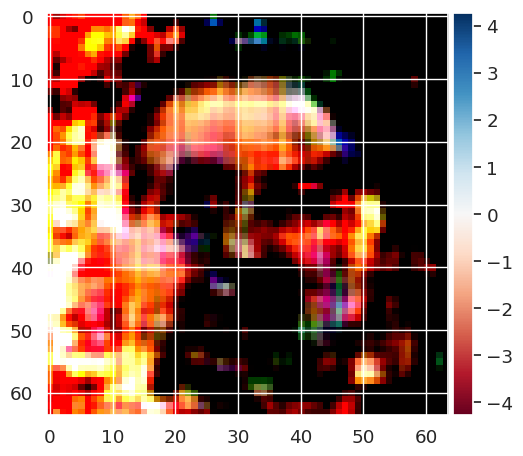

In [80]:
show_images(fake_images.detach().cpu())

In [26]:
torch.cuda.empty_cache()

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [27]:
!ls -1 /kaggle/input/faces-dataset-small/faces_dataset_small/ | wc -l

3143


In [30]:
def makedata():
    real_images_list=[]
    fake_images_list=[]
    for real_images, _ in train_dl:
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = generator(latent).detach().cpu()
            real_images_list.append(real_images)
            fake_images_list.append(fake_images)
    return fake_images_list,real_images_list

In [31]:
fake, real = makedata()

In [45]:
fake_y = torch.concat(fake).view(3584,3*64*64).numpy()
fake_y.shape

(3584, 12288)

In [46]:
# fake_y = fake_y.reshape
fake_y.shape

(3584, 12288)

In [47]:
real_y = torch.concat(real).cpu().view(3143,3*64*64).numpy()
real_y.shape

(3143, 12288)

In [48]:
real_y = real_y#.reshape(3143,3*64*64)
real_y.shape

(3143, 12288)

In [49]:
fake_y= fake_y[:3143]
fake_y.shape

(3143, 12288)

In [44]:
y = torch.concat((torch.ones(3143), torch.zeros(3143))).numpy()


In [51]:
import numpy as np
x = np.concatenate((real_y,fake_y))

In [52]:
x.shape

(6286, 12288)

In [54]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut,cross_val_score
from sklearn.manifold import TSNE
loo = LeaveOneOut()
loo.get_n_splits(y)

6286

In [ ]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=1),x.copy(),y.copy(),cv=5) 
# LeaveOneOut() не могу сделать падает из-за OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.



In [67]:
scores.mean()


0.9721613653524365

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

классы находиться близко к друг другу, генератор работает плохо

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [62]:
tsne = TSNE(n_components=2)
x_trans = tsne.fit_transform(x)

In [64]:
x_trans.shape

(6286, 2)

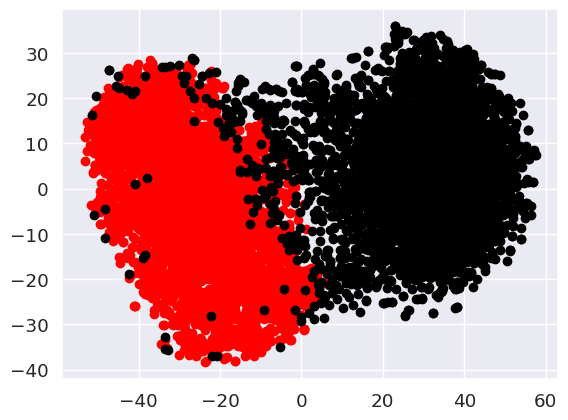

In [65]:
plt.scatter(x_trans[:3143,0] , x_trans[:3143,1] , color = 'red')
plt.scatter(x_trans[3143:,0] , x_trans[3143:,1] , color = 'black')
plt.show()

Прокомментируйте получившийся результат:

получилось плох, данные линейно разделимы 